![CAT_DOG](img/cat_dog.jpeg)

# Classifier des images de chiens et de chats avec un MLP

🎯 **Objectif du projet**

Vous devez concevoir, entraîner et évaluer un réseau de neurones de type MLP (Multilayer Perceptron) capable de distinguer des images de chiens et de chats. Ce projet vous permettra de comprendre les bases de la classification supervisée appliquée aux images, en utilisant une architecture dense simple.  

Les images des animaux se trouvent dans `data/pets`.

📝 **Recommandations techniques**
> Taille des images :
- Redimensionnez toutes les images à une taille uniforme, par exemple 64×64 pixels.
- Pour faciliter cet exercice, travaillez avec des images en niveau de gris. 
- Chaque image devra être aplatie (flatten) en un vecteur d’entrée de 4096 valeurs (64×64).
> Architecture du MLP :
- Utilisez 1 à 3 couches cachées avec des activations ReLU. Vous pouvez expérimenter d'autres fonction d'activations.
- La dernière couche doit comporter 1 seul neurone avec une activation sigmoid, car vous êtes sur une tâche de classification binaire.
> Fonction de perte :
- Utilisez impérativement la fonction binary_crossentropy, adaptée à une sortie de type sigmoid.
> Évaluation du modèle :
- Affichez la précision (accuracy) sur l’ensemble d’entraînement et de validation.
- tilisez une matrice de confusion pour analyser les erreurs.
> Prétraitement des données :
- Appliquez une normalisation des pixels (ex. : rescale=1./255) pour faciliter l’apprentissage du modèle.
> Bonnes pratiques :
- Travaillez avec un générateur d’images pour éviter de charger tout en mémoire.
- Séparez bien vos données en train / validation.
> Bonus
- Travaillez avec un générateur d’images pour éviter de charger tout en mémoire : ImageDataGenerator

# import biblio

In [2]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import cv2

In [ ]:
from PIL import Image
img = Image.open("data/pets/train/cat/140.jpg")
print(type(img))

<class 'PIL.GifImagePlugin.GifImageFile'>


# 1. Exploration des données

<class 'numpy.ndarray'>


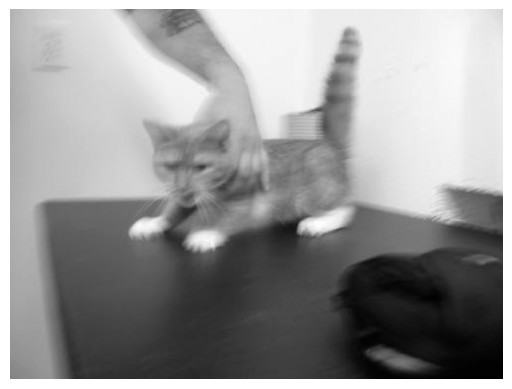

Shape (dimensions)    : (375, 500)
Type des valeurs      : uint8


In [ ]:
# On charge une image depuis un chemin local, l’image est chargé en 1 canal (valeur de pixel de 0 à 255)
img = cv2.imread("data/pets/train/cat/0.jpg",cv2.IMREAD_GRAYSCALE)
print(type(img))

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

print(f"Shape (dimensions)    : {img.shape}")
print(f"Type des valeurs      : {img.dtype}")

In [ ]:
base_path = "data/pets/train"
X = []  # liste pour stocker les images
y = []  # liste pour stocker les étiquettes correspondantes
for label in sorted(os.listdir(base_path)):
        print("label", label)
        # on ignore les fichiers qui ne sont pas des dossiers de classes dog|cat
        if label not in ["cat","dog"]:
            print("continue")
            continue
        label_path = os.path.join(base_path, label)
        print("label_path",label_path)
        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            print("file_path",file_path)
            # Lecture de l'image en niveaux de gris
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            
            if img is None:
                continue  # image illisible, on passe
            X.append(img)           # on ajoute l'image à la liste
            y.append(1 if label == "cat" else 0)    # on ajoute le label (ex: 0 (dog), 1 (cat))

label cat
label_path data/pets/train\cat
file_path data/pets/train\cat\0.jpg
file_path data/pets/train\cat\1.jpg
file_path data/pets/train\cat\10.jpg
file_path data/pets/train\cat\100.jpg
file_path data/pets/train\cat\1000.jpg
file_path data/pets/train\cat\1001.jpg
file_path data/pets/train\cat\1002.jpg
file_path data/pets/train\cat\1003.jpg
file_path data/pets/train\cat\1004.jpg
file_path data/pets/train\cat\1005.jpg
file_path data/pets/train\cat\1006.jpg
file_path data/pets/train\cat\1007.jpg
file_path data/pets/train\cat\1008.jpg
file_path data/pets/train\cat\1009.jpg
file_path data/pets/train\cat\101.jpg
file_path data/pets/train\cat\1010.jpg
file_path data/pets/train\cat\1011.jpg
file_path data/pets/train\cat\1012.jpg
file_path data/pets/train\cat\1013.jpg
file_path data/pets/train\cat\1014.jpg
file_path data/pets/train\cat\1015.jpg
file_path data/pets/train\cat\1016.jpg
file_path data/pets/train\cat\1017.jpg
file_path data/pets/train\cat\1018.jpg
file_path data/pets/train\cat\101

In [ ]:
fixed_images = []
for img in X:
    resized = cv2.resize(img, (64, 64))  # Resize to consistent shape
    fixed_images.append(resized)

X_train = np.array(fixed_images)
y_train = np.array(y)


# 2. Préparation des données

In [ ]:
def get_train_test(base_path: str):
    X = []  # liste pour stocker les images
    y = []  # liste pour stocker les étiquettes correspondantes

    # On parcourt les sous-dossiers du répertoire (un dossier par classe)
    for label in sorted(os.listdir(base_path)):
        print("label", label)
        
        # on ignore les fichiers qui ne sont pas des dossiers de classes dog|cat
        if label not in ["cat","dog"]:
            print("continue")
            continue
        label_path = os.path.join(base_path, label)
        print("label_path",label_path)
        
        # On parcourt chaque image du dossier
        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            print("file_path",file_path)
            # Lecture de l'image en niveaux de gris
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            
            if img is None:
                continue  # image illisible, on passe
            resized = cv2.resize(img, (64, 64))  # Resize to consistent shape
            X.append(resized)           # on ajoute l'image à la liste
            y.append(1 if label == "cat" else 0)    # on ajoute le label (ex: 0 (dog), 1 (cat))

    # Conversion des listes en tableaux NumPy
    X = np.array(X)
    y = np.array(y)
    return X, y



#X_train, y_train = get_train_test("data/pets/train")
X_test, y_test = get_train_test("data/pets/test")

label cat
label_path data/pets/test\cat
file_path data/pets/test\cat\10000.jpg
file_path data/pets/test\cat\10001.jpg
file_path data/pets/test\cat\10002.jpg
file_path data/pets/test\cat\10003.jpg
file_path data/pets/test\cat\10004.jpg
file_path data/pets/test\cat\10005.jpg
file_path data/pets/test\cat\10006.jpg
file_path data/pets/test\cat\10007.jpg
file_path data/pets/test\cat\10008.jpg
file_path data/pets/test\cat\10009.jpg
file_path data/pets/test\cat\10010.jpg
file_path data/pets/test\cat\10011.jpg
file_path data/pets/test\cat\10012.jpg
file_path data/pets/test\cat\10013.jpg
file_path data/pets/test\cat\10014.jpg
file_path data/pets/test\cat\10015.jpg
file_path data/pets/test\cat\10016.jpg
file_path data/pets/test\cat\10017.jpg
file_path data/pets/test\cat\10018.jpg
file_path data/pets/test\cat\10019.jpg
file_path data/pets/test\cat\10020.jpg
file_path data/pets/test\cat\10021.jpg
file_path data/pets/test\cat\10022.jpg
file_path data/pets/test\cat\10023.jpg
file_path data/pets/test

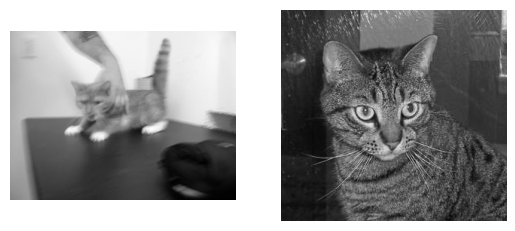

In [ ]:
# Vérification des données préparées
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(X[i], cmap="grey")
    plt.axis("off")

plt.show()

# 3. Preprocessing

In [ ]:
X_train.shape

(19961, 64, 64)

In [ ]:
# Les images sont au format (64, 64). On les convertit en float pour normaliser ensuite
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# Normalisation : on divise les valeurs de pixels par 255 pour les ramener entre 0 et 1
X_train /= 255.0
X_test /= 255.0

# Flatten : pour un MLP, chaque image 28x28 doit devenir un vecteur de 784 valeurs
X_train = X_train.reshape(X_train.shape[0], 64 * 64)
X_test = X_test.reshape(X_test.shape[0], 64 * 64)

In [ ]:
X_test.shape

(4985, 4096)

# 4. Modelisation

> Architecture du MLP :
- Utilisez 1 à 3 couches cachées avec des activations ReLU. Vous pouvez expérimenter d'autres fonction d'activations.
- La dernière couche doit comporter 1 seul neurone avec une activation sigmoid, car vous êtes sur une tâche de classification binaire.

In [ ]:
model = models.Sequential([
    layers.Input(shape=(4096,)),            # Couche d'entrée : vecteur de 784 pixels
    layers.Dense(128, activation='relu'),  # 1ère couche cachée avec 128 neurones
    layers.Dense(64, activation='relu'),   # 2e couche cachée avec 64 neurones
    layers.Dense(1, activation='sigmoid') # Couche de sortie : 1 classes (0 à 1), avec sigmoidoftmax qui permet d’obtenir une probabilité pour chaque classe
])

> Fonction de perte :
- Utilisez impérativement la fonction binary_crossentropy, adaptée à une sortie de type sigmoid.

In [ ]:
model.compile(
    optimizer='adam',                            # Méthode d’optimisation (descente de gradient)
    loss='binary_crossentropy',      # Fonction de perte pour classification avec étiquettes entières (ex : 0 à 1)
    metrics=['accuracy']                         # On surveille l’exactitude pendant l'entraînement
)

In [ ]:
# Résumé du modèle
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 532,737 (2.03 MB)

 Trainable params: 532,737 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(
    X_train, y_train,        # Données d’entraînement
    epochs=10,               # Nombre de passages sur l’ensemble du dataset
    batch_size=64            # Nombre d’images traitées avant mise à jour des poids
)

Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5278 - loss: 0.7374
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5780 - loss: 0.6742
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5881 - loss: 0.6692
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6116 - loss: 0.6573
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6187 - loss: 0.6533
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6145 - loss: 0.6493
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6149 - loss: 0.6540
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6232 - loss: 0.6454
Epoch 9/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6196 - loss: 0.6473
Epoch 10/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6367 - loss: 0.6343


# 5. Évaluation du modèle

> Évaluation du modèle :
- Affichez la précision (accuracy) sur l’ensemble d’entraînement et de validation.
- utilisez une matrice de confusion pour analyser les erreurs.

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Accuracy sur le test : {acc*100:.2f}%")

156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5181 - loss: 0.7364
Accuracy sur le test : 60.74%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


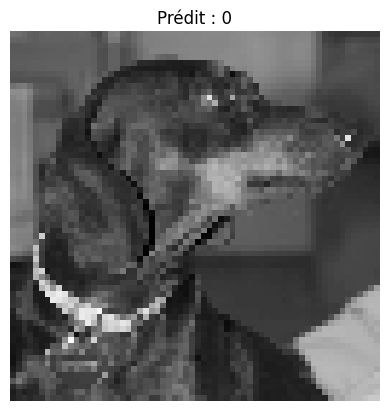

In [ ]:
# Affichage d’un chiffre avec prédiction
img_to_predict = 3456
plt.imshow(X_test[img_to_predict].reshape(64, 64),cmap="grey")
plt.title(f"Prédit : {model.predict(X_test[[img_to_predict]]).argmax()}")
plt.axis('off')
plt.show()

> Bonnes pratiques :
- Travaillez avec un générateur d’images pour éviter de charger tout en mémoire.
- Séparez bien vos données en train / validation.
> Bonus
- Travaillez avec un générateur d’images pour éviter de charger tout en mémoire : ImageDataGenerator

In [ ]:
y_pred = model.predict(X_test)
y_pred.shape

156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


(4985, 1)

In [ ]:
pd.cross_y_test